In [1]:
 # Google Colab Setup
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [0]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import imageio

In [0]:
class configuration:
    IMAGE_WIDTH = 400
    IMAGE_HEIGHT = 300
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    VGG_MODEL = 'imagenet-vgg-verydeep-19.mat' 
    STYLE_IMAGE = 'stone_style.jpg' 
    CONTENT_IMAGE = 'content300.jpg' 
    OUTPUT_DIR = 'output/'
def load_vgg_model(path):
    
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
      
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

        #return W, b
     
    def _relu(conv2d_layer):
       
        return tf.nn.relu(conv2d_layer)
      
    def _conv2d(prev_layer, layer, layer_name):
       
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b
    def _conv2d_relu(prev_layer, layer, layer_name):
    
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, configuration.IMAGE_HEIGHT, configuration.IMAGE_WIDTH, configuration.COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph
def reshape_and_normalize_image(image):   
    image = np.reshape(image, ((1,) + image.shape))  
    image = image - configuration.MEANS
    return image


def save_image(path, image):
    image = image + configuration.MEANS
    image = np.clip(image[0], 0, 255).astype('uint8')
    imageio.imwrite(path, image)



In [0]:
# compute_content_cost

def compute_content_cost(a_C, a_G):
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_C_unrolled = tf.reshape(a_C, [n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, [n_H * n_W, n_C])
    
    J_content = (1 / (4 * n_H * n_W * n_C)) * tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
    
    return J_content

In [0]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")
print(model)

In [0]:

def gram_matrix(A):
    
    GA = tf.matmul(A,tf.transpose(A))
    
    return GA

In [0]:

def compute_layer_style_cost(a_S, a_G):

    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.reshape(a_S,[n_H*n_W,n_C])
    a_G = tf.reshape(a_G,[n_H*n_W,n_C])

    GS = gram_matrix(tf.transpose(a_S))
    GG = gram_matrix(tf.transpose(a_G))

   
    J_style_layer = (tf.reduce_sum(tf.reduce_sum(tf.square(tf.subtract(GS,GG)))))/(4*(n_C * n_C) * (n_H * n_W)*(n_H * n_W))
    
 
    return J_style_layer

In [0]:
def similarity_loss( a_C , a_G ):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
   
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled =(tf.reshape(a_C,[n_H*n_W,n_C])) 
    a_G_unrolled = (tf.reshape(a_G,[n_H*n_W,n_C]))
    
    J_similarity= tf.reduce_sum(tf.keras.losses.MAE(a_C_unrolled , a_G_unrolled))
  
  
    return J_similarity



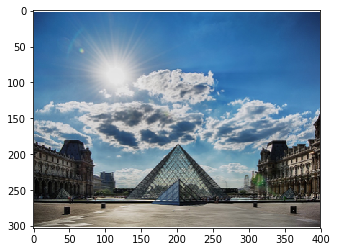

In [32]:
def interact():
  model = load_vgg_model("imagenet-vgg-verydeep-19.mat")
  content_image = imageio.imread("louvre.png")
  imshow(content_image)

interact()